### [ML Guide](https://spark.apache.org/docs/latest/ml-guide.html)
### [Pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html)
### [VectorAssembler](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html)
### [RMSE](https://towardsdatascience.com/what-does-rmse-really-mean-806b65f2e48e)
### [StringIndexer](https://spark.apache.org/docs/latest/ml-features#stringindexer)


<center><img src="https://miro.medium.com/max/1360/1*GGiYnKAAV_Y5VMfRrSOpXA.png"/>
</center>

# Vamos criar um modelo de predição de potência de um carro



<center><img src="https://carsughi.uol.com.br/wp-content/uploads/2020/08/os-10-carros-mais-potentes-do-mundo-conheca-a-lista-6.jpg"/>
</center>

## Machine Learning é um Workflow

### Conceitos

- **Transformer: **Transforma o DF em outro DF;
- **Estimator: **Chama o metodo fit para produzir o transformer;
- **Pipilene: **Conecta os Transformers e Estimatos para produzir o modelo;
- **Parâmetros: **Transformers e Estimatos compartilham uma API para definir os parâmetros

In [1]:
# Já temos tudo configurado, basta agora instalar em nosso notebook e realizar as configurações

!conda install pyspark -y

Solving environment: done

# All requested packages already installed.



In [2]:
# Pacotes necessários para rodarmos o Spark

import findspark
findspark.find()
findspark.init()
import pyspark

In [3]:
# Criando a API

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Spark_ML") \
    .getOrCreate()

In [4]:
# Criando a API

from pyspark.ml.regression import LinearRegression, RandomForestRegressor # bibliotecas para regressão
from pyspark.ml.evaluation import RegressionEvaluator # metodo de avaliação para regressão
from pyspark.ml.feature import VectorAssembler # transforma dados categóricos em numéricos

In [6]:
# lendo o dataset

car_temp = spark.read.csv("/media/clayton/NewDisk/Ai2/12-Spark/data/Carros.csv", inferSchema=True, header=True, sep=';')
car_temp.show(5)

+-------+---------+-----------+---------------+----+-----+---------+-----------+-------+-----------+---+
|Consumo|Cilindros|Cilindradas|RelEixoTraseiro|Peso|Tempo|TipoMotor|Transmissao|Marchas|Carburadors| HP|
+-------+---------+-----------+---------------+----+-----+---------+-----------+-------+-----------+---+
|     21|        6|        160|             39| 262| 1646|        0|          1|      4|          4|110|
|     21|        6|        160|             39|2875| 1702|        0|          1|      4|          4|110|
|    228|        4|        108|            385| 232| 1861|        1|          1|      4|          1| 93|
|    214|        6|        258|            308|3215| 1944|        1|          0|      3|          1|110|
|    187|        8|        360|            315| 344| 1702|        0|          0|      3|          2|175|
+-------+---------+-----------+---------------+----+-----+---------+-----------+-------+-----------+---+
only showing top 5 rows



In [7]:
# Informações sobre o dataset:

print("O conjunto de dados possui %d linhas e %d colunas"%(car_temp.count(), len(car_temp.columns)))

O conjunto de dados possui 32 linhas e 11 colunas


In [8]:
# Tipo das colunas

car_temp.dtypes

[('Consumo', 'int'),
 ('Cilindros', 'int'),
 ('Cilindradas', 'int'),
 ('RelEixoTraseiro', 'int'),
 ('Peso', 'int'),
 ('Tempo', 'int'),
 ('TipoMotor', 'int'),
 ('Transmissao', 'int'),
 ('Marchas', 'int'),
 ('Carburadors', 'int'),
 ('HP', 'int')]

In [11]:
# Algumas informações sobre as colunas

car_temp.describe().toPandas()

,summary,Consumo,Cilindros,Cilindradas,RelEixoTraseiro,Peso,Tempo,TipoMotor,Transmissao,Marchas,Carburadors,HP
0,count,32,32,32,32,32,32,32,32,32,32,32
1,mean,177.5625,6.1875,796.34375,318.03125,1257.78125,969.8125,0.4375,0.40625,3.6875,2.8125,146.6875
2,stddev,84.01303182321794,1.7859216469465444,794.5358803232033,122.42482469504664,1534.3700763668455,832.5501220017696,0.5040161287741853,0.49899091723584604,0.7378040652569471,1.6151999776318522,68.56286848932059
3,min,15,4,79,3,22,18,0,0,3,1,52
4,max,339,8,2758,493,5424,2022,1,1,5,8,335


In [12]:
# Verificando quantidade de valores nulos 

from pyspark.sql.functions import isnull, when, count, col

car_temp.select([count(when(isnull(c), c)).alias(c) for c in car_temp.columns]).show()

+-------+---------+-----------+---------------+----+-----+---------+-----------+-------+-----------+---+
|Consumo|Cilindros|Cilindradas|RelEixoTraseiro|Peso|Tempo|TipoMotor|Transmissao|Marchas|Carburadors| HP|
+-------+---------+-----------+---------------+----+-----+---------+-----------+-------+-----------+---+
|      0|        0|          0|              0|   0|    0|        0|          0|      0|          0|  0|
+-------+---------+-----------+---------------+----+-----+---------+-----------+-------+-----------+---+



In [13]:
# Para prever a potência (Horse Power - HP), vamos utilizar apenas 3 das variáveis apresentadas:

car_pred = car_temp.select("Consumo", "Cilindros","Cilindradas","HP")
car_pred.show(5)

+-------+---------+-----------+---+
|Consumo|Cilindros|Cilindradas| HP|
+-------+---------+-----------+---+
|     21|        6|        160|110|
|     21|        6|        160|110|
|    228|        4|        108| 93|
|    214|        6|        258|110|
|    187|        8|        360|175|
+-------+---------+-----------+---+
only showing top 5 rows



In [15]:
# Criando vetor de características com VectorAssembler — 
# um transformador de recursos que mescla várias colunas em uma coluna de vetor.

vec_feat = VectorAssembler(inputCols=[("Consumo"),("Cilindros"),("Cilindradas")], outputCol="caracteristicas")
car_pred = vec_feat.transform(car_pred)
car_pred.show(5)

IllegalArgumentException: Output column caracteristicas already exists.

In [17]:
# Spliting dataset

car_train, car_test = car_pred.randomSplit([0.7, 0.3])
print(car_train.count())

19


### Vamos criar nosso primeiro modelo - LR

In [18]:
# Criando o modelo regressão linear (passo a coluna com variáveis independentes e variável dependente)
# Criando o objeto LinearRegression

regre_lin = LinearRegression(featuresCol="caracteristicas", labelCol="HP")

In [19]:
# Agora, vamos criar nosso modelo passando o conjunto de treinamento

modelo = regre_lin.fit(car_train)

In [20]:
# Realizando a predição com o modelo treinado e o conjunto de testes

previsao = modelo.transform(car_test)
previsao.show(5)

+-------+---------+-----------+---+------------------+------------------+
|Consumo|Cilindros|Cilindradas| HP|   caracteristicas|        prediction|
+-------+---------+-----------+---+------------------+------------------+
|     21|        6|        160|110|  [21.0,6.0,160.0]|186.29684773536448|
|     26|        4|       1203| 91| [26.0,4.0,1203.0]|120.23911841030724|
|    104|        8|        472|205| [104.0,8.0,472.0]|220.44462304342676|
|    152|        8|       2758|180|[152.0,8.0,2758.0]|188.26883202100888|
|    155|        8|        318|150| [155.0,8.0,318.0]|  210.919926283179|
+-------+---------+-----------+---+------------------+------------------+
only showing top 5 rows



In [21]:
# RMSE para apresentar a taxa de erro do modelo

evaluate = RegressionEvaluator(predictionCol="prediction", labelCol="HP", metricName="rmse")
rmse = evaluate.evaluate(previsao)
print(rmse)

36.967422422761956


### Vamos criar nosso segundo modelo - RF

In [22]:
# Utilizando agora o RandonForest

rand_fos = RandomForestRegressor(featuresCol="caracteristicas", labelCol="HP")
modelo2 = rand_fos.fit(car_train)

In [24]:
previsao2 = modelo2.transform(car_test)
previsao2.show(5)

+-------+---------+-----------+---+------------------+------------------+
|Consumo|Cilindros|Cilindradas| HP|   caracteristicas|        prediction|
+-------+---------+-----------+---+------------------+------------------+
|     21|        6|        160|110|  [21.0,6.0,160.0]|135.52946428571428|
|     26|        4|       1203| 91| [26.0,4.0,1203.0]|139.93936507936507|
|    104|        8|        472|205| [104.0,8.0,472.0]|207.73263888888886|
|    152|        8|       2758|180|[152.0,8.0,2758.0]|185.45138888888886|
|    155|        8|        318|150| [155.0,8.0,318.0]| 182.5347222222222|
+-------+---------+-----------+---+------------------+------------------+
only showing top 5 rows



In [25]:
# Comparando os resultados

previsao.show()

+-------+---------+-----------+---+------------------+------------------+
|Consumo|Cilindros|Cilindradas| HP|   caracteristicas|        prediction|
+-------+---------+-----------+---+------------------+------------------+
|     21|        6|        160|110|  [21.0,6.0,160.0]|186.29684773536448|
|     26|        4|       1203| 91| [26.0,4.0,1203.0]|120.23911841030724|
|    104|        8|        472|205| [104.0,8.0,472.0]|220.44462304342676|
|    152|        8|       2758|180|[152.0,8.0,2758.0]|188.26883202100888|
|    155|        8|        318|150| [155.0,8.0,318.0]|  210.919926283179|
|    158|        8|        351|264| [158.0,8.0,351.0]|209.95805948054763|
|    181|        6|        225|105| [181.0,6.0,225.0]|151.18166382234818|
|    192|        8|        400|175| [192.0,8.0,400.0]|202.16010187700672|
|    197|        6|        145|175| [197.0,6.0,145.0]| 148.4960739114773|
|    228|        4|        108| 93| [228.0,4.0,108.0]| 87.14515180679537|
|    228|        4|       1408| 95|[22

In [26]:
rmse2 = evaluate.evaluate(previsao2)
print(rmse2)

34.74515206415242


## Vamos agora executar um exemplo de classificação



Vamos agora utilizar um conjunto de dados que está relacionado com campanhas de marketing direto (telefonemas) de uma instituição bancária portuguesa. 
O objetivo da classificação é prever se o cliente irá subscrever (Sim/Não) um depósito a prazo. 
O conjunto de dados pode ser baixado do [Kaggle](https://www.kaggle.com/rouseguy/bankbalanced/version/1).

In [27]:
# Construindo a nova API

spark2 = SparkSession.builder.appName('Ai2_ml-bank').getOrCreate()
df = spark.read.csv('/media/clayton/NewDisk/Ai2/12-Spark/data/bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [28]:
# Visualizando os dados

df.toPandas()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
6,56,management,married,tertiary,no,830,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
7,60,retired,divorced,secondary,no,545,yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
8,37,technician,married,secondary,no,1,yes,no,unknown,6,may,608,1,-1,0,unknown,yes
9,28,services,single,secondary,no,5090,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes


In [29]:
# Podemos melhor visualizar os dados com o Pandas

import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [30]:
# Removendo colunas que não serão utilizadas (dia e mês)

df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



## Preparando os dados

Este processo inclui Indexação de Categoria, Codificação do One HotEncoder e VectorAssembler

In [31]:
# Colunas com dados categóricos

df

DataFrame[age: int, job: string, marital: string, education: string, default: string, balance: int, housing: string, loan: string, contact: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, deposit: string]

In [32]:
# importando as bibliotecas

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [33]:
# Pegando as colunas com dados categoricos

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

In [34]:
categoricalColumns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'poutcome']

In [35]:
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

In [36]:
# StringIndexer na coluna deposito (label)

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

In [37]:
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [42]:
# COmo ficou nossa coluna de features??

df.select("label").show()

+-----+
|label|
+-----+
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
|  1.0|
+-----+
only showing top 20 rows



## Pipeline

Usamos o Pipeline para encadear vários transformadores e estimadores para especificar nosso fluxo de trabalho de aprendizado de máquina. Os estágios de um pipeline são especificados como uma matriz ordenada.

In [39]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [40]:
# selecionando apenas uma coluna

df.select("features").show()

+--------------------+
|            features|
+--------------------+
|(30,[3,11,13,16,1...|
|(30,[3,11,13,16,1...|
|(30,[2,11,13,16,1...|
|(30,[4,11,13,16,1...|
|(30,[3,11,14,16,1...|
|(30,[0,12,14,16,2...|
|(30,[0,11,14,16,2...|
|(30,[5,13,16,18,2...|
|(30,[2,11,13,16,1...|
|(30,[4,12,13,16,1...|
|(30,[3,12,13,16,1...|
|(30,[1,11,13,16,1...|
|(30,[0,11,14,16,2...|
|(30,[1,12,14,16,1...|
|(30,[2,12,14,16,1...|
|(30,[0,14,16,18,2...|
|(30,[1,12,15,16,1...|
|(30,[4,11,13,16,1...|
|(30,[3,11,13,16,1...|
|(30,[3,13,16,20,2...|
+--------------------+
only showing top 20 rows



In [44]:
feat1 = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
ass2 = VectorAssembler(inputCols=feat1, outputCol='saida')
trans = ass2.transform(df)
trans.select('saida').show()

+--------------------+
|               saida|
+--------------------+
|[59.0,2343.0,1042...|
|[56.0,45.0,1467.0...|
|[41.0,1270.0,1389...|
|[55.0,2476.0,579....|
|[54.0,184.0,673.0...|
|[42.0,0.0,562.0,2...|
|[56.0,830.0,1201....|
|[60.0,545.0,1030....|
|[37.0,1.0,608.0,1...|
|[28.0,5090.0,1297...|
|[38.0,100.0,786.0...|
|[30.0,309.0,1574....|
|[29.0,199.0,1689....|
|[46.0,460.0,1102....|
|[31.0,703.0,943.0...|
|[35.0,3837.0,1084...|
|[32.0,611.0,541.0...|
|[49.0,-8.0,1119.0...|
|[41.0,55.0,1120.0...|
|[49.0,168.0,513.0...|
+--------------------+
only showing top 20 rows



In [43]:
# Vamos agora ver como esta nosso Dataset

pd.DataFrame(df.take(5), columns=df.columns)

,label,features,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,deposit
0,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,admin.,married,secondary,no,2343,yes,no,unknown,1042,1,-1,0,unknown,yes
1,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56,admin.,married,secondary,no,45,no,no,unknown,1467,1,-1,0,unknown,yes
2,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",41,technician,married,secondary,no,1270,yes,no,unknown,1389,1,-1,0,unknown,yes
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",55,services,married,secondary,no,2476,yes,no,unknown,579,1,-1,0,unknown,yes
4,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",54,admin.,married,tertiary,no,184,no,no,unknown,673,2,-1,0,unknown,yes


## Spliting Dataset

In [45]:
train, test = df.randomSplit([0.7, 0.3])
print("Amostras Conjunto de Treinamento: " + str(train.count()))
print("Amostras Conjunto de Teste: " + str(test.count()))

Amostras Conjunto de Treinamento: 7769
Amostras Conjunto de Teste: 3393


In [46]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [47]:
# Listando os coeficientes

lrModel.coefficients

DenseVector([-0.0369, -0.2516, 0.0066, 0.2023, -0.0753, 0.7318, -0.1587, 0.7873, 0.0496, -0.3101, -0.3156, -0.1355, 0.1965, -0.0672, 0.196, -0.2105, 0.2471, 0.7961, 0.5361, -0.0691, -1.3199, -0.6343, -0.212, 2.033, -0.0038, 0.0, 0.005, -0.1266, -0.0001, 0.0043])

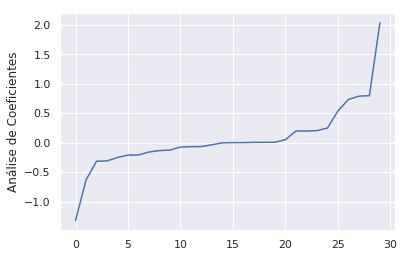

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

plot_lr = np.sort(lrModel.coefficients)
plt.plot(plot_lr)
plt.ylabel('Análise de Coeficientes')
plt.show()

/opt/spark/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


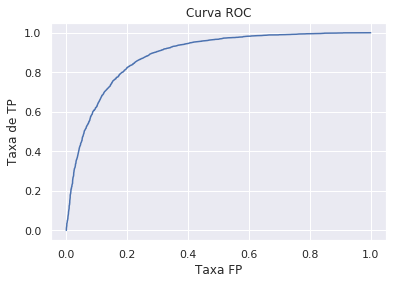

Conjunto de treinamento sobre a curva ROC: 0.8856461397709963


In [50]:
# Curva ROC

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('Taxa de TP')
plt.xlabel('Taxa FP')
plt.title('Curva ROC')
plt.show()
print('Conjunto de treinamento sobre a curva ROC: ' + str(trainingSummary.areaUnderROC))

### Classificador de árvore de decisão

As árvores de decisão são amplamente utilizadas, pois são fáceis de interpretar, manipulam recursos categóricos, estendem-se à classificação multiclasse, não requerem dimensionamento de recursos e são capazes de capturar não linearidades e interações de recursos.

In [52]:
# Predições no conjunto de testes

from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('label','prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.83372921615201...|
|  0.0|       0.0|[0.83372921615201...|
|  0.0|       0.0|[0.83372921615201...|
|  0.0|       1.0|[0.21219612690564...|
|  0.0|       0.0|[0.83372921615201...|
|  0.0|       1.0|[0.21219612690564...|
|  0.0|       0.0|[0.94662921348314...|
|  0.0|       0.0|[0.94662921348314...|
|  0.0|       0.0|[0.83372921615201...|
|  0.0|       0.0|[0.83372921615201...|
+-----+----------+--------------------+
only showing top 10 rows



In [53]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.780995345551522


## Resultados

Uma árvore de decisão simples teve um desempenho ruim porque é muito fraca, dada a variedade de recursos diferentes. A precisão da previsão de árvores de decisão pode ser melhorada por métodos de Ensemble, como Random Forest e Gradient-Boosted Tree.

## Utilizando agora Random Forest

In [54]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('label', 'prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.61253986406654...|
|  0.0|       0.0|[0.62572132773481...|
|  0.0|       0.0|[0.65794644668077...|
|  0.0|       1.0|[0.37583443931499...|
|  0.0|       0.0|[0.60369598164011...|
|  0.0|       1.0|[0.33731687517119...|
|  0.0|       0.0|[0.81756456197358...|
|  0.0|       0.0|[0.77169353664379...|
|  0.0|       0.0|[0.86633006680105...|
|  0.0|       0.0|[0.68425884383794...|
+-----+----------+--------------------+
only showing top 10 rows



In [55]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8777761406046122


## Agora Gradient-Boosted Tree Classifier


In [56]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('label','prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.93269375069460...|
|  0.0|       0.0|[0.93269375069460...|
|  0.0|       0.0|[0.89845255529563...|
|  0.0|       1.0|[0.28121666654037...|
|  0.0|       1.0|[0.46594786724660...|
|  0.0|       1.0|[0.17118361139691...|
|  0.0|       0.0|[0.74221990851833...|
|  0.0|       0.0|[0.93106470215512...|
|  0.0|       0.0|[0.93945915969761...|
|  0.0|       0.0|[0.88469881921355...|
+-----+----------+--------------------+
only showing top 10 rows



In [57]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8911715262842934


## Resultados

Gradient-Boosted Tree obteve os melhores resultados, tentaremos ajustar este modelo com o ParamGridBuilder e o CrossValidator. Antes disso, podemos usar explainParams() para imprimir uma lista de todos os parâmetros e suas definições para entender quais parâmetros estão disponíveis para ajuste.

In [58]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Executar validações cruzadas. Isso pode levar alguns minutos, pois está treinando mais de 20 árvores!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8974692437862317

## Conclusão

Para resumir, construimos um aplicativo de classificação binária usando a API PySpark e MLlib Pipelines utilizando diferentes algoritmos e o Gradient-Boosted Tree teve o melhor desempenho em nosso conjunto de dados.